In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import gc
import torch
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import optuna
from optuna.integration import KerasPruningCallback
import lightning
from collections import deque

lightning.seed_everything(12345)
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", font_scale=1.2, palette="muted")
plt.rcParams["figure.figsize"] = [12, 4]

%matplotlib inline

/home/ventus/university/data-mining/.env/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 12345


In [2]:
df = pd.read_csv("../data/mpi_saale_2021b.csv", parse_dates=['Date Time'], index_col='Date Time')["T (degC)"]

sequence_length = 30
dataset = keras.utils.timeseries_dataset_from_array(
    df.values, df.values[sequence_length:], sequence_length
)

num_samples = len(dataset)
train_size = int(0.7 * num_samples)
val_size = int(0.2 * num_samples)
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size)

2025-04-13 17:06:38.616463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744556798.629057  233821 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744556798.632722  233821 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744556798.643409  233821 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744556798.643426  233821 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744556798.643428  233821 computation_placer.cc:177] computation placer alr

In [3]:
from keras import ops
from keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Embedding, Lambda
from keras.models import Model

def transformer_encoder(inputs, num_heads, ff_dim, dropout_rate=0.1):
    # Multi-head Self-Attention
    causal_mask = np.tril(np.ones((sequence_length, sequence_length))).astype("bool")
    attention_layer = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])
    attn_output, attn_scores = attention_layer(inputs, inputs, return_attention_scores=True, attention_mask=causal_mask)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    # Feed-forward Network
    ffn_output = Dense(ff_dim, activation='relu')(out1)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn_output), attn_scores

def build_transformer_forecasting_model(trial: optuna.Trial):
    num_heads = trial.suggest_categorical("num_heads", [1, 2, 4])
    ff_dim = trial.suggest_int("ff_dim", 64, 128, step=32)
    in_dim = trial.suggest_int("in_dim", 64, 128, step=32)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    inputs = Input(shape=(sequence_length, 1))  # univariate input
    
    
    x = Dense(in_dim)(inputs)
    positions = Lambda(lambda t: ops.arange(ops.shape(t)[1]))(inputs) 
    pos_embedding = Embedding(input_dim=sequence_length, output_dim=in_dim)(positions)
    x = x + pos_embedding
    # Add Transformer Encoder blocks
    x, attn_scores = transformer_encoder(x, num_heads, ff_dim, dropout_rate=dropout)
    for _ in range(num_layers-1):
        x, _ = transformer_encoder(x, num_heads, ff_dim, dropout_rate=dropout)
    
    # Global average pooling or just take the last time step
    x = x[:, -1, :]  # take the last step's representation
    x = Dense(ff_dim, activation='relu')(x)
    outputs = Dense(1)(x)  # predict next value

    model = Model(inputs, outputs)
    model.attention = Model(inputs, outputs=attn_scores)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mse")
    return model

In [4]:
from keras.callbacks import EarlyStopping

def objective_transformer(trial):
    model = build_transformer_forecasting_model(trial)

    early_stop = EarlyStopping(patience=5, restore_best_weights=True)
    pruning_cb = KerasPruningCallback(trial, monitor="val_loss")

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=30,
        verbose=0,
        callbacks=[early_stop, pruning_cb],
    )

    return min(history.history["val_loss"])

In [5]:
def make_study(name: str):
	return optuna.create_study(
		direction="minimize",
		study_name=name,
		storage="sqlite:///../data/lab4-optuna.db",
		load_if_exists=True,
		pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
	)

In [6]:
def fit_best_transformer(trial: optuna.Trial):
    best_model = build_transformer_forecasting_model(trial)
    best_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=100,
        batch_size=8,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    )
    return best_model

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_prediction(targets, predictions):
	# Plot actual vs predicted values
	plt.figure(figsize=(12, 6))
	plt.plot(targets, label="True Values")
	plt.plot(predictions, label="Predicted Values", color="darkred")
	plt.xlabel("Time Step")
	plt.ylabel("Temperature (degC)")
	plt.title("True vs Predicted Temperature")
	plt.legend()
	plt.show()

	# Compute MAE and RMSE
	mae = mean_absolute_error(targets, predictions)
	rmse = mean_squared_error(targets, predictions)**0.5

	print(f"Mean Absolute Error (MAE): {mae}")
	print(f"Root Mean Squared Error (RMSE): {rmse}")

def evaluate_candidate(model):
	# Get model predictions for the test dataset
	test_features = np.vstack([x[0] for x in test_ds])
	test_target = np.hstack([x[1] for x in test_ds])

	# Make predictions
	test_predictions = model.predict(test_features)
	evaluate_prediction(test_target, test_predictions)

def forecast(model, horizon=30, index=0):
	x, y = next(iter(test_ds.skip(index)))
	targets = y[:horizon]
	sequence = deque(x[0], maxlen=sequence_length)
	for _ in range(horizon):
		pred = model.predict(
			np.reshape(sequence, (1, sequence_length, 1)),
			verbose=0,
		)
		sequence.append(pred[0,0])
	evaluate_prediction(np.hstack([x[0], targets]), np.hstack([x[0], list(sequence)[-horizon:]]))

	attention = model.attention.predict(x)
	avg_attention = attention.mean(axis=1)[0]  # mean over heads, first sample
	plt.figure(figsize=(10, 6))
	sns.heatmap(avg_attention, cmap="viridis", xticklabels=False, yticklabels=False)
	plt.title("Average Attention Weights (Input → Input)")
	plt.xlabel("Key Time Step")
	plt.ylabel("Query Time Step")
	plt.show()

In [8]:
# optuna.study.delete_study(study_name="transformer_forecasting", storage="sqlite:///../data/lab4-optuna.db")
study = make_study("transformer_forecasting")
study.optimize(objective_transformer, n_trials=0, n_jobs=5)

[I 2025-04-13 17:06:40,549] Using an existing study with name 'transformer_forecasting' instead of creating a new one.


In [9]:
%%time
best_transformer = fit_best_transformer(study.best_trial)

Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 89.0373 - val_loss: 16.0595
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 36.5558 - val_loss: 22.2280
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 37.2035 - val_loss: 4.5475
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 29.4026 - val_loss: 3.0620
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 34.5906 - val_loss: 3.2027
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 28.7909 - val_loss: 4.2547
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 33.6805 - val_loss: 2.1394
Epoch 8/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 22.4698 - val_loss: 2.6014
Epoch 9/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 17.2955 - val_loss: 1.3119
Epoch 10/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 3.0572 - val_loss: 1.1986
Epoch 11/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.7892 - val_loss: 1.3947
Epoch 12/100
144/14

2025-04-13 17:07:41.444175: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


19/88 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

2025-04-13 17:07:41.740789: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


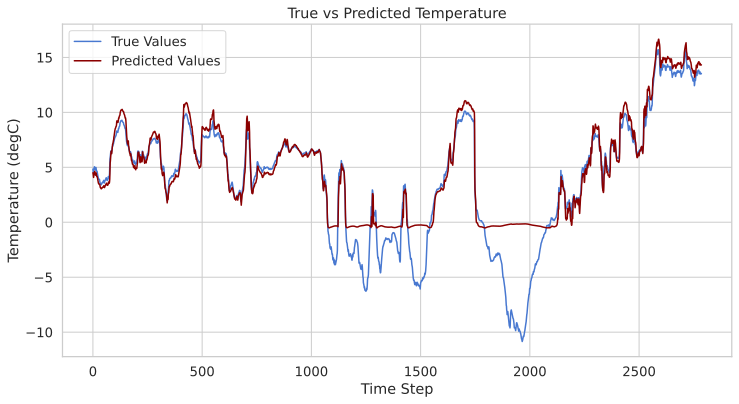

Mean Absolute Error (MAE): 1.298318719790509
Root Mean Squared Error (RMSE): 2.3414832041256783


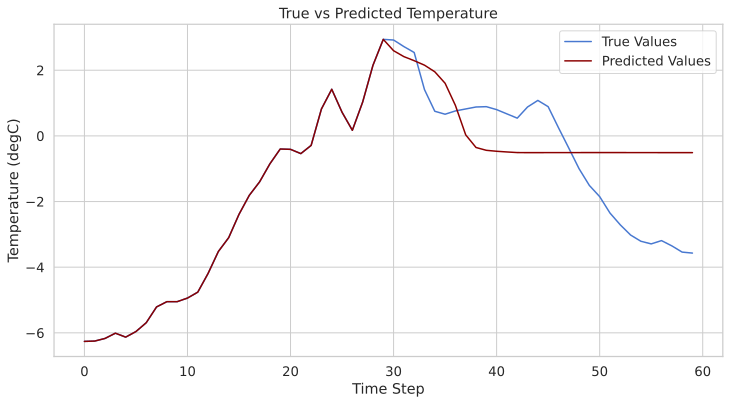

Mean Absolute Error (MAE): 0.7087592591295641
Root Mean Squared Error (RMSE): 1.1871536589898344
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


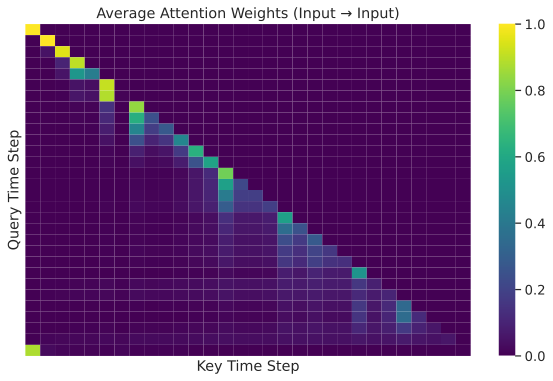

In [10]:
evaluate_candidate(best_transformer)
forecast(best_transformer, index=10)

## No causal mask equals shortcuts?

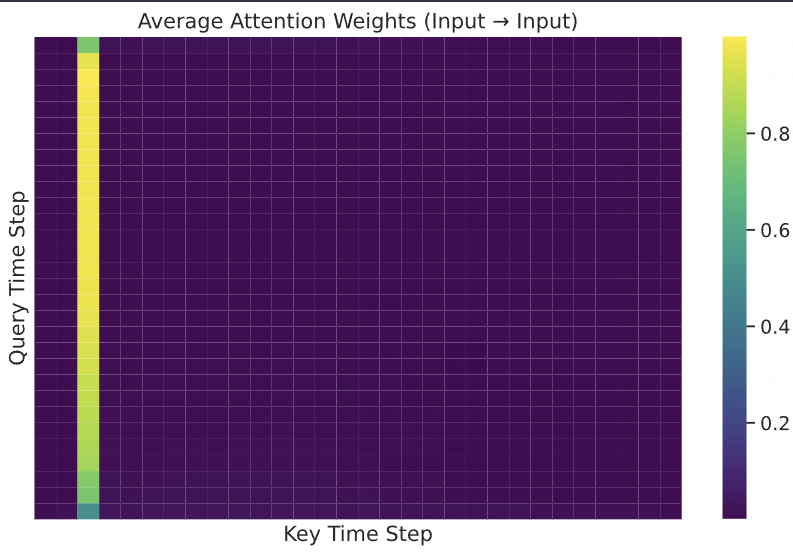